## 准备数据和训练回归模型

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# 生成一些模拟数据
np.random.seed(42)
X = np.random.rand(100, 1)  # 100个样本，1个特征
y = 5 * X.squeeze() + np.random.randn(100) * 0.5  # 线性关系加上噪声

# 将数据分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练一个简单的线性回归模型
model = LinearRegression()
model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = model.predict(X_test)


## 计算符合性度量
符合性度量可以通过计算每个预测值的残差来进行。对于回归任务，残差是预测值与实际值之间的差异。

In [2]:
# 计算训练集上的残差
train_residuals = y_train - model.predict(X_train)

# 计算符合性度量：我们使用绝对残差来作为符合性度量
conformity_scores = np.abs(train_residuals)

# 对训练集上的残差进行排序
conformity_scores_sorted = np.sort(conformity_scores)
conformity_scores_sorted


array([0.0051074 , 0.01357008, 0.01978722, 0.03017447, 0.03032776,
       0.03321593, 0.04147916, 0.06432236, 0.07037285, 0.07198976,
       0.07344529, 0.07751263, 0.08706409, 0.09865022, 0.11523007,
       0.1213176 , 0.12421308, 0.12998153, 0.13840404, 0.13989027,
       0.14701517, 0.14782318, 0.15677071, 0.16690423, 0.17803409,
       0.18024177, 0.18184223, 0.1849167 , 0.19062228, 0.19563931,
       0.1990547 , 0.19938788, 0.20274411, 0.20466868, 0.22778849,
       0.22969617, 0.24806194, 0.28755686, 0.29054099, 0.33168371,
       0.33568969, 0.35385512, 0.3550739 , 0.36142899, 0.361499  ,
       0.36378622, 0.36940061, 0.37215213, 0.38026871, 0.38508497,
       0.38734224, 0.40538019, 0.44967078, 0.48698895, 0.4963907 ,
       0.50160996, 0.50685571, 0.51749964, 0.52209273, 0.55642539,
       0.58485016, 0.58827401, 0.600705  , 0.61529687, 0.65425583,
       0.66801684, 0.67914637, 0.68761957, 0.69102098, 0.69180743,
       0.69249353, 0.72680399, 0.74477134, 0.76879664, 0.83706

## 构建置信区间
为了构建置信区间，我们首先计算出在训练集上的残差排序，基于这些排序来定义符合性阈值。我们选择一个置信度（例如 95%），并确保预测区间包含真实值的概率为 95%。


In [3]:
# 设置置信度
confidence_level = 0.95
n_train = len(y_train)

# 计算对应的临界值
k = int(np.floor(confidence_level * n_train))  # 索引对应的临界点
epsilon = conformity_scores_sorted[k]  # 临界值，即95%分位数的残差

# 为每个测试集样本计算置信区间
lower_bound = y_pred - epsilon
upper_bound = y_pred + epsilon

# 打印一些结果
for i in range(5):  # 打印前5个样本的预测结果及其区间
    print(f"预测值: {y_pred[i]:.2f}, 置信区间: [{lower_bound[i]:.2f}, {upper_bound[i]:.2f}]")


预测值: 0.38, 置信区间: [-0.57, 1.32]
预测值: 4.37, 置信区间: [3.42, 5.31]
预测值: 3.78, 置信区间: [2.83, 4.72]
预测值: 3.25, 置信区间: [2.31, 4.20]
预测值: 1.31, 置信区间: [0.37, 2.26]


## 可视化

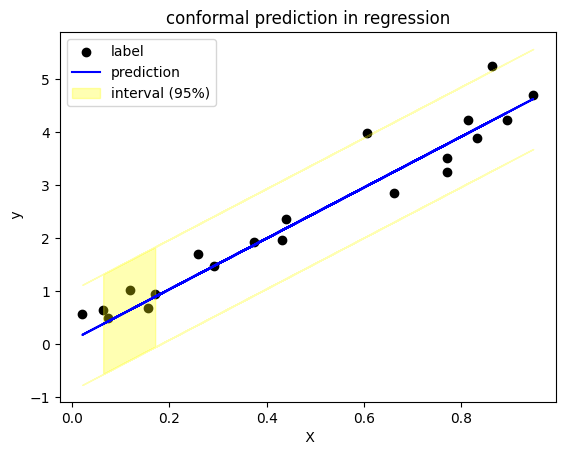

In [7]:
plt.scatter(X_test, y_test, color='black', label='label')
plt.plot(X_test, y_pred, color='blue', label='prediction')
plt.fill_between(X_test.squeeze(), lower_bound, upper_bound, color='yellow', alpha=0.3, label='interval (95%)')

plt.xlabel(' X')
plt.ylabel(' y')
plt.legend()
plt.title('conformal prediction in regression')
plt.show()


In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

# 创建一个简单的分类数据集
X, y = make_classification(n_samples=200, n_features=20, n_classes=2, random_state=42)

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练一个支持向量机（SVM）分类器
model = SVC(probability=True)
model.fit(X_train, y_train)

# 获取训练集的预测概率
train_probs = model.predict_proba(X_train)

# 计算每个训练样本的残差（这里用预测概率与真实标签的差）
train_residuals = np.abs(train_probs[np.arange(len(y_train)), y_train] - 1)

# 定义共形预测的置信度
alpha = 0.1  # 置信度为90%

# 获取测试集的预测概率
test_probs = model.predict_proba(X_test)

# 使用训练残差来进行共形预测
def conformal_prediction(test_probs, train_residuals, alpha=0.1):
    predictions = []
    for prob in test_probs:
        # 计算该样本的每个类别的置信度区间
        p_values = np.abs(prob - 1)  # 计算与训练样本残差的差
        p_values_sorted = np.sort(np.concatenate([train_residuals, p_values]))  # 排序
        threshold = p_values_sorted[int((1-alpha) * len(p_values_sorted))]  # 计算阈值
        valid_classes = np.where(np.abs(prob - 1) <= threshold)[0]  # 找到符合阈值的类别
        
        if len(valid_classes) == 1:
            predictions.append(valid_classes[0])
        else:
            predictions.append(valid_classes)  # 如果多个类别符合阈值，则返回多个可能的类别
    return predictions

# 获取共形预测的结果
conformal_preds = conformal_prediction(test_probs, train_residuals, alpha)

# 评估共形预测结果
correct_preds = [1 if pred == true else 0 for pred, true in zip(conformal_preds, y_test)]
accuracy = sum(correct_preds) / len(correct_preds)

print(f"共形预测的准确率：{accuracy:.2f}")


共形预测的准确率：0.72


/tmp/ipykernel_2296820/264197450.py:49: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  correct_preds = [1 if pred == true else 0 for pred, true in zip(conformal_preds, y_test)]
